In [2]:
import json
import pandas as pd
import os
from dotenv import load_dotenv
import fitz  # PyMuPDF
from pathlib import Path
from typing import Dict, Optional, Tuple, List

import google.generativeai as genai

# Table Extraction Method 2

1.   pass in image table into VLM
2.   get json output of basic table structure as it visually is (not all combinations)
3.   search through json output OR expand all combinations programmatically

### prompts

In [64]:
system_instruction = "You are a table data extraction system. Process the ENTIRE table and output ALL combinations in JSON format. Do not truncate, summarize, or ask for confirmation. Output the complete data in one response."

prompt_text = """
I want you to parse a furniture pricing table from the image attached and output the data in JSON format.
The table describes combinations of attributes, each represented by row and column headers. Your task is to produce the output below

TASK INPUT: 
An image of a complex table with pricing information based on several attributes, such as color codes, finishing, dimensions, etc.
There might be nested sub-categories and some columns might be combined

TASK OUTPUT: 
A JSON array of objects, where each object represents the price for each combination of attributes in the table. Output the complete list of objects. The JSON format should be:
[
  {
    attribute 1: attribute 1 value,
    attribute 2: attribute 2 value,
    attribute 3: attribute 3 value,
    attribute X: attribute X value,
    price: price in EUR from image
  }
]

<examples>
<example>
input:
"""
prompt_text2 = """
output:
[{"Telaio":"frN / frNC / frRB / fr71 / fr73","Seduta":"Ecopelle / C.O.M.","Dimensions_CM":"53,5x59x86h","Dimensions_INCHES":"21¹/₈x23¹/₄x33⁷/₈h","M3":"0,48","Colli":"2","EUR":"705"},{"Telaio":"frN / frNC / frRB / fr71 / fr73","Seduta":"Tessuto / Synthetic nubuck / Micro nubuck / C.O.L","Dimensions_CM":"53,5x59x86h","Dimensions_INCHES":"21¹/₈x23¹/₄x33⁷/₈h","M3":"0,48","Colli":"2","EUR":"738"},{"Telaio":"frN / frNC / frRB / fr71 / fr73","Seduta":"Pelle","Dimensions_CM":"53,5x59x86h","Dimensions_INCHES":"21¹/₈x23¹/₄x33⁷/₈h","M3":"0,48","Colli":"2","EUR":"818"},{"Telaio":"frN / frNC / frRB / fr71 / fr73","Seduta":"Pelle Glove","Dimensions_CM":"53,5x59x86h","Dimensions_INCHES":"21¹/₈x23¹/₄x33⁷/₈h","M3":"0,48","Colli":"2","EUR":"858"},{"Telaio":"frN / frNC / frRB / fr71 / fr73","Seduta":"Ecopelle / C.O.M.","Dimensions_CM":"B 53,5x59x86h","Dimensions_INCHES":"21¹/₈x23¹/₄x33⁷/₈h","M3":"0,36","Colli":"1","EUR":"818"},{"Telaio":"frN / frNC / frRB / fr71 / fr73","Seduta":"Tessuto / Synthetic nubuck / Micro nubuck / C.O.L","Dimensions_CM":"B 53,5x59x86h","Dimensions_INCHES":"21¹/₈x23¹/₄x33⁷/₈h","M3":"0,36","Colli":"1","EUR":"871"},{"Telaio":"frN / frNC / frRB / fr71 / fr73","Seduta":"Pelle","Dimensions_CM":"B 53,5x59x86h","Dimensions_INCHES":"21¹/₈x23¹/₄x33⁷/₈h","M3":"0,36","Colli":"1","EUR":"972"},{"Telaio":"frN / frNC / frRB / fr71 / fr73","Seduta":"Pelle Glove","Dimensions_CM":"B 53,5x59x86h","Dimensions_INCHES":"21¹/₈x23¹/₄x33⁷/₈h","M3":"0,36","Colli":"1","EUR":"1.023"}]
</example>

<example>
input:
"""

prompt_text3 = """
output:
[{"Top":"NC / RB","Base":"GFM69 / GFM73 - 06","Dimensions_CM":"B 250x128x75h","Dimensions_INCHES":"98³/₈x50³/₈x29¹/₂h","M3":"1,05","Colli":"3","EUR":"3.570"},{"Top":"NC / RB","Base":"GFM11 / GFM18 - 06","Dimensions_CM":"B 250x128x75h","Dimensions_INCHES":"98³/₈x50³/₈x29¹/₂h","M3":"1,05","Colli":"3","EUR":"3.589"},{"Top":"NC / RB","Base":"GFM69 / GFM73 - 06","Dimensions_CM":"B 300x128x75h","Dimensions_INCHES":"118¹/₈x50³/₈x29¹/₂h","M3":"1,13","Colli":"4","EUR":"3.719"},{"Top":"NC / RB","Base":"GFM11 / GFM18 - 06","Dimensions_CM":"B 300x128x75h","Dimensions_INCHES":"118¹/₈x50³/₈x29¹/₂h","M3":"1,13","Colli":"4","EUR":"3.738"}]
</example>

<example>
input:
"""

prompt_text4 = """
output:
[{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"220V","Dimensions_CM":"S1 ø62x66h","Dimensions_INCHES":"ø24³/₈x26h","M3":"0,33","Colli":"1","EUR":"764"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"110V","Dimensions_CM":"S1 ø62x66h","Dimensions_INCHES":"ø24³/₈x26h","M3":"0,33","Colli":"1","EUR":"787"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"220V","Dimensions_CM":"S2 ø82x73h","Dimensions_INCHES":"ø32¹/₄x28³/₄h","M3":"0,67","Colli":"1","EUR":"1.313"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"110V","Dimensions_CM":"S2 ø82x73h","Dimensions_INCHES":"ø32¹/₄x28³/₄h","M3":"0,67","Colli":"1","EUR":"1.351"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"220V","Dimensions_CM":"P1 ø62x138h","Dimensions_INCHES":"ø24³/₈x54³/₈h","M3":"0,74","Colli":"1","EUR":"1.082"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"110V","Dimensions_CM":"P1 ø62x138h","Dimensions_INCHES":"ø24³/₈x54³/₈h","M3":"0,74","Colli":"1","EUR":"1.112"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"220V","Dimensions_CM":"P2 ø82x149h","Dimensions_INCHES":"ø32¹/₄x58⁵/₈h","M3":"1,34","Colli":"1","EUR":"1.455"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"110V","Dimensions_CM":"P2 ø82x149h","Dimensions_INCHES":"ø32¹/₄x58⁵/₈h","M3":"1,34","Colli":"1","EUR":"1.500"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"220V","Dimensions_CM":"Cavo aggiuntivo 1 mt versione S","EUR":"17"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"110V","Dimensions_CM":"Cavo aggiuntivo 1 mt versione S","EUR":"39"}]
</example>
</examples>
"""

few_shot_examples = [
    {
        "input_text": "EXAMPLE 2:",
        "image_path": "./few-shot-examples/table-image-chair.png",
        "output": """
          [{"Telaio":"frN / frNC / frRB / fr71 / fr73","Seduta":"Ecopelle / C.O.M.","Dimensions_CM":"53,5x59x86h","Dimensions_INCHES":"21¹/₈x23¹/₄x33⁷/₈h","M3":"0,48","Colli":"2","EUR":"705"},{"Telaio":"frN / frNC / frRB / fr71 / fr73","Seduta":"Tessuto / Synthetic nubuck / Micro nubuck / C.O.L","Dimensions_CM":"53,5x59x86h","Dimensions_INCHES":"21¹/₈x23¹/₄x33⁷/₈h","M3":"0,48","Colli":"2","EUR":"738"},{"Telaio":"frN / frNC / frRB / fr71 / fr73","Seduta":"Pelle","Dimensions_CM":"53,5x59x86h","Dimensions_INCHES":"21¹/₈x23¹/₄x33⁷/₈h","M3":"0,48","Colli":"2","EUR":"818"},{"Telaio":"frN / frNC / frRB / fr71 / fr73","Seduta":"Pelle Glove","Dimensions_CM":"53,5x59x86h","Dimensions_INCHES":"21¹/₈x23¹/₄x33⁷/₈h","M3":"0,48","Colli":"2","EUR":"858"},{"Telaio":"frN / frNC / frRB / fr71 / fr73","Seduta":"Ecopelle / C.O.M.","Dimensions_CM":"B 53,5x59x86h","Dimensions_INCHES":"21¹/₈x23¹/₄x33⁷/₈h","M3":"0,36","Colli":"1","EUR":"818"},{"Telaio":"frN / frNC / frRB / fr71 / fr73","Seduta":"Tessuto / Synthetic nubuck / Micro nubuck / C.O.L","Dimensions_CM":"B 53,5x59x86h","Dimensions_INCHES":"21¹/₈x23¹/₄x33⁷/₈h","M3":"0,36","Colli":"1","EUR":"871"},{"Telaio":"frN / frNC / frRB / fr71 / fr73","Seduta":"Pelle","Dimensions_CM":"B 53,5x59x86h","Dimensions_INCHES":"21¹/₈x23¹/₄x33⁷/₈h","M3":"0,36","Colli":"1","EUR":"972"},{"Telaio":"frN / frNC / frRB / fr71 / fr73","Seduta":"Pelle Glove","Dimensions_CM":"B 53,5x59x86h","Dimensions_INCHES":"21¹/₈x23¹/₄x33⁷/₈h","M3":"0,36","Colli":"1","EUR":"1.023"}]
        """
    },
    {
        "input_text": "EXAMPLE 1:",
        "image_path": "./few-shot-examples/table-image-desk2.png",
        "output": """
          [{"Top":"NC / RB","Base":"GFM69 / GFM73 - 06","Dimensions_CM":"B 250x128x75h","Dimensions_INCHES":"98³/₈x50³/₈x29¹/₂h","M3":"1,05","Colli":"3","EUR":"3.570"},{"Top":"NC / RB","Base":"GFM11 / GFM18 - 06","Dimensions_CM":"B 250x128x75h","Dimensions_INCHES":"98³/₈x50³/₈x29¹/₂h","M3":"1,05","Colli":"3","EUR":"3.589"},{"Top":"NC / RB","Base":"GFM69 / GFM73 - 06","Dimensions_CM":"B 300x128x75h","Dimensions_INCHES":"118¹/₈x50³/₈x29¹/₂h","M3":"1,13","Colli":"4","EUR":"3.719"},{"Top":"NC / RB","Base":"GFM11 / GFM18 - 06","Dimensions_CM":"B 300x128x75h","Dimensions_INCHES":"118¹/₈x50³/₈x29¹/₂h","M3":"1,13","Colli":"4","EUR":"3.738"}]
        """
    },
    {
        "input_text": "EXAMPLE 3:",
        "image_path": "./few-shot-examples/table-image-lamp.png",
        "output": """
          [{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"220V","Dimensions_CM":"S1 ø62x66h","Dimensions_INCHES":"ø24³/₈x26h","M3":"0,33","Colli":"1","EUR":"764"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"110V","Dimensions_CM":"S1 ø62x66h","Dimensions_INCHES":"ø24³/₈x26h","M3":"0,33","Colli":"1","EUR":"787"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"220V","Dimensions_CM":"S2 ø82x73h","Dimensions_INCHES":"ø32¹/₄x28³/₄h","M3":"0,67","Colli":"1","EUR":"1.313"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"110V","Dimensions_CM":"S2 ø82x73h","Dimensions_INCHES":"ø32¹/₄x28³/₄h","M3":"0,67","Colli":"1","EUR":"1.351"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"220V","Dimensions_CM":"P1 ø62x138h","Dimensions_INCHES":"ø24³/₈x54³/₈h","M3":"0,74","Colli":"1","EUR":"1.082"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"110V","Dimensions_CM":"P1 ø62x138h","Dimensions_INCHES":"ø24³/₈x54³/₈h","M3":"0,74","Colli":"1","EUR":"1.112"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"220V","Dimensions_CM":"P2 ø82x149h","Dimensions_INCHES":"ø32¹/₄x58⁵/₈h","M3":"1,34","Colli":"1","EUR":"1.455"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"110V","Dimensions_CM":"P2 ø82x149h","Dimensions_INCHES":"ø32¹/₄x58⁵/₈h","M3":"1,34","Colli":"1","EUR":"1.500"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"220V","Dimensions_CM":"Cavo aggiuntivo 1 mt versione S","EUR":"17"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"110V","Dimensions_CM":"Cavo aggiuntivo 1 mt versione S","EUR":"39"}]
        """
    }
]

few_shot_examples_gpt = [
    {
        "input_text": f"EXAMPLE 1:{prompt_text}",
        "image_path": "https://smartcatalog.blob.core.windows.net/table-images/table-image-desk2.png",
        "output": """
          [{"Top":"NC / RB","Base":"GFM69 / GFM73 - 06","Dimensions_CM":"B 250x128x75h","Dimensions_INCHES":"98³/₈x50³/₈x29¹/₂h","M3":"1,05","Colli":"3","EUR":"3.570"},{"Top":"NC / RB","Base":"GFM11 / GFM18 - 06","Dimensions_CM":"B 250x128x75h","Dimensions_INCHES":"98³/₈x50³/₈x29¹/₂h","M3":"1,05","Colli":"3","EUR":"3.589"},{"Top":"NC / RB","Base":"GFM69 / GFM73 - 06","Dimensions_CM":"B 300x128x75h","Dimensions_INCHES":"118¹/₈x50³/₈x29¹/₂h","M3":"1,13","Colli":"4","EUR":"3.719"},{"Top":"NC / RB","Base":"GFM11 / GFM18 - 06","Dimensions_CM":"B 300x128x75h","Dimensions_INCHES":"118¹/₈x50³/₈x29¹/₂h","M3":"1,13","Colli":"4","EUR":"3.738"}]
        """
    },
    {
        "input_text": f"EXAMPLE 2:{prompt_text}",
        "image_path": "https://smartcatalog.blob.core.windows.net/table-images/table-image-chair.png",
        "output": """
          [{"Telaio":"frN / frNC / frRB / fr71 / fr73","Seduta":"Ecopelle / C.O.M.","Dimensions_CM":"53,5x59x86h","Dimensions_INCHES":"21¹/₈x23¹/₄x33⁷/₈h","M3":"0,48","Colli":"2","EUR":"705"},{"Telaio":"frN / frNC / frRB / fr71 / fr73","Seduta":"Tessuto / Synthetic nubuck / Micro nubuck / C.O.L","Dimensions_CM":"53,5x59x86h","Dimensions_INCHES":"21¹/₈x23¹/₄x33⁷/₈h","M3":"0,48","Colli":"2","EUR":"738"},{"Telaio":"frN / frNC / frRB / fr71 / fr73","Seduta":"Pelle","Dimensions_CM":"53,5x59x86h","Dimensions_INCHES":"21¹/₈x23¹/₄x33⁷/₈h","M3":"0,48","Colli":"2","EUR":"818"},{"Telaio":"frN / frNC / frRB / fr71 / fr73","Seduta":"Pelle Glove","Dimensions_CM":"53,5x59x86h","Dimensions_INCHES":"21¹/₈x23¹/₄x33⁷/₈h","M3":"0,48","Colli":"2","EUR":"858"},{"Telaio":"frN / frNC / frRB / fr71 / fr73","Seduta":"Ecopelle / C.O.M.","Dimensions_CM":"B 53,5x59x86h","Dimensions_INCHES":"21¹/₈x23¹/₄x33⁷/₈h","M3":"0,36","Colli":"1","EUR":"818"},{"Telaio":"frN / frNC / frRB / fr71 / fr73","Seduta":"Tessuto / Synthetic nubuck / Micro nubuck / C.O.L","Dimensions_CM":"B 53,5x59x86h","Dimensions_INCHES":"21¹/₈x23¹/₄x33⁷/₈h","M3":"0,36","Colli":"1","EUR":"871"},{"Telaio":"frN / frNC / frRB / fr71 / fr73","Seduta":"Pelle","Dimensions_CM":"B 53,5x59x86h","Dimensions_INCHES":"21¹/₈x23¹/₄x33⁷/₈h","M3":"0,36","Colli":"1","EUR":"972"},{"Telaio":"frN / frNC / frRB / fr71 / fr73","Seduta":"Pelle Glove","Dimensions_CM":"B 53,5x59x86h","Dimensions_INCHES":"21¹/₈x23¹/₄x33⁷/₈h","M3":"0,36","Colli":"1","EUR":"1.023"}]
        """
    },
    {
        "input_text": f"EXAMPLE 3:{prompt_text}",
        "image_path": "https://smartcatalog.blob.core.windows.net/table-images/table-image-lamp.png",
        "output": """
          [{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"220V","Dimensions_CM":"S1 ø62x66h","Dimensions_INCHES":"ø24³/₈x26h","M3":"0,33","Colli":"1","EUR":"764"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"110V","Dimensions_CM":"S1 ø62x66h","Dimensions_INCHES":"ø24³/₈x26h","M3":"0,33","Colli":"1","EUR":"787"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"220V","Dimensions_CM":"S2 ø82x73h","Dimensions_INCHES":"ø32¹/₄x28³/₄h","M3":"0,67","Colli":"1","EUR":"1.313"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"110V","Dimensions_CM":"S2 ø82x73h","Dimensions_INCHES":"ø32¹/₄x28³/₄h","M3":"0,67","Colli":"1","EUR":"1.351"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"220V","Dimensions_CM":"P1 ø62x138h","Dimensions_INCHES":"ø24³/₈x54³/₈h","M3":"0,74","Colli":"1","EUR":"1.082"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"110V","Dimensions_CM":"P1 ø62x138h","Dimensions_INCHES":"ø24³/₈x54³/₈h","M3":"0,74","Colli":"1","EUR":"1.112"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"220V","Dimensions_CM":"P2 ø82x149h","Dimensions_INCHES":"ø32¹/₄x58⁵/₈h","M3":"1,34","Colli":"1","EUR":"1.455"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"110V","Dimensions_CM":"P2 ø82x149h","Dimensions_INCHES":"ø32¹/₄x58⁵/₈h","M3":"1,34","Colli":"1","EUR":"1.500"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"220V","Dimensions_CM":"Cavo aggiuntivo 1 mt versione S","EUR":"17"},{"Struttura":"OP17 / Nichel","Rivestimento":"Avorio / Marrone / Nero","Impianto":"110V","Dimensions_CM":"Cavo aggiuntivo 1 mt versione S","EUR":"39"}]
        """
    }
]

## Claude prompt setup, processing, calling

In [109]:
from anthropic import Anthropic
import base64

load_dotenv()
anthropic_api_key = os.getenv("ANTHROPIC_API_KEY")
client = Anthropic(api_key=anthropic_api_key)


In [16]:
# ENCODE IMAGES TO BASE64 FOR CLAUDE COMPATIBILITY
def encode_image_to_base64(image_path):
    with open(image_path, 'rb') as image_file:
        return base64.standard_b64encode(image_file.read()).decode("utf-8")

In [17]:
# BUILD THE COMPLETE MESSAGES ARRAY (PROMPT BUILDER)
def build_prompt(prompt_text, prompt_image, few_shot_examples=None):
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/png",
                        "data": encode_image_to_base64(prompt_image)
                    },
                },
                {
                    "type": "text",
                    "text": prompt_text
                },
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/png",
                        "data": encode_image_to_base64(few_shot_examples[0]["image_path"])
                    },
                },
                {
                    "type": "text",
                    "text": prompt_text2
                },
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/png",
                        "data": encode_image_to_base64(few_shot_examples[1]["image_path"])
                    },
                },
                {
                    "type": "text",
                    "text": prompt_text3
                },
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/png",
                        "data": encode_image_to_base64(few_shot_examples[2]["image_path"])
                    },
                },
                {
                    "type": "text",
                    "text": prompt_text4
                }
            ],
        },
        {"role": "assistant", "content": "["} # pre-fill response so it can get to the fkn point
    ]
    return messages


In [60]:
# MAIN FUNCTION TO PROCESS IMAGE WITH CLAUDE
def process_image_claude(prompt_image, prompt_text, sys_instruction="", few_shot_examples=None):
    try:
        messages = build_prompt(prompt_text, prompt_image, few_shot_examples)
        response = client.messages.create(
            model="claude-3-5-sonnet-20241022",
            system=sys_instruction,
            messages=messages,
            temperature=0.5,
            max_tokens=8192
        )
        result = response.content[0].text.strip()
        if result.startswith("{"):
            return "[" + result
        else:
            return result
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return None

call claude & convert output to dataframe

In [65]:
image_url = "./files/table-image-desk3.png"  # Replace with your image URL
def extract_price_data(image_path):  
    return process_image_claude(image_path, prompt_text, system_instruction, few_shot_examples)

response = extract_price_data(image_url)
# print(response)

In [63]:
# CHECKING OUTPUT
data_json = json.loads(response)
print(len(data_json))
pd.DataFrame.from_records(data_json)

27


,Base,Top,Dimensions_CM,Dimensions_INCHES,M3,Colli,EUR
0,GFM69 / GFM73,KM02 / KM04 / KM05 / KM06 / KM09 / KM10 / KM11...,"200x106x73,5h",78³/₄x41³/₄x28⁷/₈h,"0,79",5,3.458
1,GFM69 / GFM73,KM07 / KM08,"200x100x73,5h",78³/₄x39³/₈x28⁷/₈h,"0,77",5,3.437
2,GFM69 / GFM73,KM02 / KM04 / KM05 / KM06 / KM09 / KM10 / KM11...,"200x120x73,5h sag",78³/₄x47¹/₄x28⁷/₈h shaped,"0,86",5,3.711
3,GFM69 / GFM73,KM07 / KM08,"200x120x73,5h sag",78³/₄x47¹/₄x28⁷/₈h shaped,"0,86",5,3.711
4,GFM69 / GFM73,KM02 / KM04 / KM05 / KM06 / KM09 / KM10 / KM11...,"240x120x73,5h",94¹/₈x47¹/₄x28⁷/₈h,"0,90",5,3.717
5,GFM69 / GFM73,KM07 / KM08,"240x120x73,5h",94¹/₈x47¹/₄x28⁷/₈h,"0,90",5,3.717
6,GFM69 / GFM73,KM02 / KM04 / KM05 / KM06 / KM09 / KM10 / KM11...,"240x120x73,5h sag",94¹/₈x47¹/₄x28⁷/₈h shaped,"0,90",5,3.852
7,GFM69 / GFM73,KM07 / KM08,"240x120x73,5h sag",94¹/₈x47¹/₄x28⁷/₈h shaped,"0,90",5,3.852
8,GFM69 / GFM73,KM02 / KM04 / KM05 / KM06 / KM09 / KM10 / KM11...,"300x120x73,5h",118¹/₈x47¹/₄x28⁷/₈h,"1,06",5,4.873
9,GFM69 / GFM73,KM07 / KM08,"300x120x73,5h",118¹/₈x47¹/₄x28⁷/₈h,"1,06",5,4.873


## gemini setup, file upload, processing

In [ ]:
# import os
# import google.generativeai as genai

# # Create the model
# generation_config = {
#   "response_mime_type": "application/json",
#   "temperature": 0.8
# }

# genai.configure(api_key=userdata.get('gemini_api_key'))
# model = genai.GenerativeModel(
#     "gemini-1.5-pro-002"
#     # generation_config=generation_config
#     # system_instruction=""
# )

# UPLOAD TABLE IMAGE TO GEMINI
def upload_to_gemini(path, mime_type=None):
  # """Uploads the given file to Gemini.
  # See https://ai.google.dev/gemini-api/docs/prompting_with_media
  # """
  file = genai.upload_file(path, mime_type=mime_type)
  print(f"Uploaded file '{file.display_name}' as: {file.uri}")
  return file

def process_image_gemini(image_path, prompt, examples=None, generation_config=None):
    # Upload the image to Gemini
    target_image = upload_to_gemini(image_path, mime_type="image/png")

    prompt_parts = []
    # add prompt
    prompt_parts.extend([
        target_image,
        prompt
    ])
    # add examples
    if examples:
        for example in examples:
            example_image = upload_to_gemini(example['image_path'], mime_type="image/png")

            # Add example input (image and text)
            prompt_parts.extend([
                "<EXAMPLE>\nINPUT:",
                example['input_text'],
                example_image,
                "\nOUTPUT:",
                example['output'],
                "\n</EXAMPLE>\n---\n"
            ])

    # print(prompt_parts)

    # Create the prompt object
    prompt_obj = {
        "parts": prompt_parts
    }

    # Generate content using the Gemini model
    if generation_config:
        response = model.generate_content(prompt_obj, generation_config=generation_config)
    else:
        response = model.generate_content(prompt_obj)

    print(response.text)
    return response.text


In [ ]:
image1 = "/content/table-image.png"
image_data = process_image_gemini(image1, prompt_text, examples=few_shot_examples, generation_config=generation_config)
image2 = "/content/table-image-desk3.png"
image_data_desk3 = process_image_gemini(image2, prompt_text, examples=few_shot_examples, generation_config=generation_config)
image3 = "/content/table-image-madia.png"
image_data_madia = process_image_gemini(image3, prompt_text, examples=few_shot_examples, generation_config=generation_config)

Uploaded file 'table-image.png' as: https://generativelanguage.googleapis.com/v1beta/files/t27edmrjeohs
Uploaded file 'table-image-desk2.png' as: https://generativelanguage.googleapis.com/v1beta/files/izcy8w5f5c2x
Uploaded file 'table-image-chair.png' as: https://generativelanguage.googleapis.com/v1beta/files/7iszhlgeconv
Uploaded file 'table-image-lamp.png' as: https://generativelanguage.googleapis.com/v1beta/files/83q7clnj2f98
[{"Top":"CrystalMatt CY01 / CY02","Base":"GFM69 / GFM73 - 06","MISURA_CM":"240x120x74h","INCHES":"94¹/₂x47¹/₄x29¹/₈h","m³":"0,98","colli":"3","EUR":"3.192"},{"Top":"CrystalMatt CY01 / CY02","Base":"GFM11 / GFM18 - 06","MISURA_CM":"240x120x74h","INCHES":"94¹/₂x47¹/₄x29¹/₈h","m³":"0,98","colli":"3","EUR":"3.211"},{"Top":"CrystalMatt CY01 / CY02","Base":"GFM69 / GFM73 - 06","MISURA_CM":"240x120x74h sag","INCHES":"94¹/₂x47¹/₄x29¹/₈h shaped","m³":"0,98","colli":"3","EUR":"3.370"},{"Top":"CrystalMatt CY01 / CY02","Base":"GFM11 / GFM18 - 06","MISURA_CM":"240x120x74h s

In [ ]:
import json
import pandas as pd

data_json = json.loads(image_data)
print(data_json)
print(len(data_json))

data_json2 = json.loads(image_data_desk3)
print(len(data_json2))

data_json3 = json.loads(image_data_madia)
print(len(data_json3))

NameError: name 'image_data' is not defined

In [ ]:
pd.DataFrame.from_records(data_json)

## GPT-4o prompt setup, processing function, calling

In [ ]:
def create_prompt_gpt4o(prompt_image, prompt_text, few_shot_examples=None, sys_instruction=None):
  prompt = []
  # Add the system instruction
  if sys_instruction:
    prompt.append({"role": "system", "content": sys_instruction})

  # add the few shot examples
  for example in few_shot_examples:
    prompt.append({"role": "user", "content": [{"type": "text", "text": example["input_text"]}, {"type": "image_url", "image_url": { "url": example["image_path"] }}]})
    prompt.append({"role": "assistant", "content": example["output"]})

  # Add the actual user prompt
  prompt.append({"role": "user", "content": [
      {
          "type": "text",
          "text": prompt_text
      },
      {
          "type": "image_url",
          "image_url": { "url": prompt_image }
      }
  ]})
  return prompt

In [ ]:
import openai
from openai import AzureOpenAI
from google.colab import userdata

OAI_API_KEY = userdata.get('gpt_api_key')
# endpoint = "https://gpt-document-parsing.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview"
ENDPOINT = "https://gpt-document-parsing.openai.azure.com/"
deployment_model = "gpt-4o"

# Set up your Azure OpenAI client
client = AzureOpenAI(
    api_key=OAI_API_KEY,  # Replace with your Azure OpenAI API key
    azure_endpoint=ENDPOINT,  # Replace with your Azure endpoint
    api_version="2024-08-01-preview"  # Ensure the API version matches the one you set up in Azure
)

# Gpt 4o API request function
def process_image_gpt4o(image_path, prompt_input, examples=None):
    # you put together the prompt including the few-shot examples with images
    prompt = create_prompt_gpt4o(image_path, prompt_input, examples)
    print(prompt)

    try:
        # Send the request to the OpenAI API
        response = client.chat.completions.create(
            model=deployment_model,  # Replace with your deployment model name
            messages=prompt,
            temperature=0.7,
            max_tokens=8062,
            top_p=0.95,
            response_format={
                "type": "json_object"
            }
        )

        # Parse the response
        structured_data = response.to_dict().get("choices", [{}])[0].get("message", {}).get("content", "").strip()

        print(f"Output from LLM:")
        print(structured_data)
        return structured_data
    except Exception as e:
        print(f"Failed to parse response, Error: {str(e)}")
        return None

image_path_gpt = "https://smartcatalog.blob.core.windows.net/table-images/table-image.png"
gpt_output = process_image_gpt4o(image_path_gpt, prompt_text, few_shot_examples_gpt)

### The output i got from the above from GPT-4o
# {"Top":"CrystalArt CY01 / CY02","Base":"GFM69 / GFM73 - 06","Dimensions_CM":"240x120x74h","Dimensions_INCHES":"94¹/₂x47¹/₄x29¹/₈h","M3":"0,98","Colli":"3","EUR":"3.192"}


[{'role': 'user', 'content': [{'type': 'text', 'text': 'EXAMPLE 1:\nI want you to parse a furniture pricing table from the image attached and output the data in JSON format.\nThe table describes combinations of attributes, each represented by row and column headers. Your task is to produce the output below\n\nTASK INPUT: \nAn image of a complex table with pricing information based on several attributes, such as color codes, finishing, dimensions, etc.\nThere might be nested sub-categories and some columns might be combined\n\nTASK OUTPUT: \nA JSON array of objects, where each object represents the price for each combination of attributes in the table. The JSON format should be:\n[\n  {\n    attribute 1: attribute 1 value,\n    attribute 2: attribute 2 value,\n    attribute 3: attribute 3 value,\n    attribute X: attribute X value,\n    price: price in EUR from image\n  },\n  ... // More objects for other combinations\n]\n'}, {'type': 'image_url', 'image_url': {'url': 'https://smartcata

# From BoQ to exact data extraction
1. take as input 1 line of a Bill of Quantities in the format: product name, brand name, product type, ...
2. find the product in the PDF catalogs available (start with just 1)
3. get the non-price attributes for the product (name, brand, type, colors, etc) along with the page reference number. Some headers in the price table like 'color' might have code names like GFM18 which we need to map to the actual color name
4. find the price table or tables for our product & isolate them as images
5. extract price data for the product using table extraction method 2
6. combine the product data with the price data into one cohesive json data structure that also includes the page reference
7. return the result to the user well-formatted showing product name, brand name, designer etc. Show price if the exact specs were provided in the BoQ. Otherwise include the whole list of prices based on filters

**sub-steps for STEP 4 above**: *"find the price table or tables for our product & isolate them as images"*
1. find the name of the next product immediately after ours. If the next product already exists on the current page, we already know it. How? We will use the output from the gemini api call earlier that provided a structured output of all products on that page to check this. 
2. If there are none after ours in that output, either we have reached the end of the document or the current product extends to the next page or pages. If we have reached end of document, we will take all price tables after our product's y-coordinate.
3. if not end of doc, we will need to take the contents of the next page, then pass it into gemini api call asking it to identify if there are any new product names in this text or if its just a continuation of an older one. We will provide examples to gemini of what product names look like so it can do a better job at identifying this. Its important that we ask it to return the FIRST name it encounters in the same order as it appears in the text
4. we will continue going over the next set of pages until we find a product name and then store its y-coordinate & page number using fitz.
5. then we will iterate over the pages that are between the y-coordinate ranges and their respective page numbers, collecting tables on each page (using fitz find_tables method) that fit between the y-coordinates and adding them to a list so we can segment them into individual screenshots for further processing

In [82]:
def find_first_prod_on_page_gemini(page_text: str) -> Optional[str]:
    """Find first product name on a page if any exist"""
    model = setup_gemini()
    
    prompt = f"""Analyze the furniture catalog page text below and identify if there are any product names. 
    Our goal is to determine if this page content contains new products or its just a continuation of the product on the last page. 
    Product names are typically in ALL CAPS and often followed by designer name and year.
    Return ONLY the first product name you find (in order of appearance) without saying anything else, or "NO_PRODUCT" if none found.

    Examples of output product names:
    - "BUTTERFLY KERAMIK"
    - "ATLANTIS CRYSTALART"
    - "SPYDER KERAMIK"

    <page_text>
    {page_text}
    </page_text>
    """
    
    try:
        response = model.generate_content(prompt)
        result = response.candidates[0].content.parts[0].text.strip()
        
        if result == "NO_PRODUCT":
            return None
        return result
        
    except Exception as e:
        print(f"Error in Gemini API call: {str(e)}")
        return None

def find_next_product_location(doc: fitz.Document, current_page: int, 
                             current_product: str, products_on_page: dict) -> Optional[dict]:
    """
    Find the next product's location after current product.
    
    Args:
        doc: PDF document
        current_page: Current page number
        current_product: Name of current product
        products_on_page: Gemini output containing products info for current page
        
    Returns:
        dict with page_num and y_coord of next product, or None if at end
    """
    # 1. Check if next product exists on current page using old gemini output
    product_names = list(products_on_page.keys())
    
    print("prod names: ")
    print(product_names)
    try:
        current_index = product_names.index(current_product.upper())
        print("current index: ", current_index)
        if current_index + 1 < len(product_names):
            next_product = product_names[current_index + 1]
            print("next prod: ", next_product)

            # Find y-coordinate of next product
            instances = doc[current_page].search_for(next_product.upper())
            print("y coord: ", instances)
            return {
                "page_num": current_page,
                "y_coord": instances[0].y0,
                "product_name": next_product
            }
    except ValueError:
        print(f"Warning: {current_product} not found in products list")
    
    # 2. If not found, check next pages
    for page_num in range(current_page + 1, len(doc)):
        try:
            page = doc[page_num]
            next_product = find_first_prod_on_page_gemini(page.get_text())
            
            if next_product:
                # Get y-coordinate of found product
                instances = page.search_for(next_product.upper())
                if instances:
                    return {
                        "page_num": page_num,
                        "y_coord": instances[0].y0,
                        "product_name": next_product
                    }
        except Exception as e:
            print(f"Error processing page {page_num}: {str(e)}")
            continue  # Skip to next page if there's an error

    return None  # No next product found (end of document)

def get_product_price_tables(doc: fitz.Document, start_page: int, end_page: Optional[int],
                           start_y: float, end_y: Optional[float]) -> List[dict]:
    """
    Get all price tables between two y-coordinates across pages.
    
    Args:
        doc: PDF document
        start_page: Starting page number
        end_page: Ending page number (None if end of doc)
        start_y: Starting y-coordinate
        end_y: Ending y-coordinate (None if end of page)
        
    Returns:
        List of table info dictionaries
    """
    tables = []
    end_page = end_page or len(doc)-1
    
    for page_num in range(start_page, end_page + 1):
        page = doc[page_num]
        page_tables = page.find_tables()
        
        for table in page_tables:
            table_bbox = table.bbox
            
            # Check if table is within our y-coordinate range
            if page_num == start_page and table_bbox[1] < start_y:
                continue
            if page_num == end_page and end_y and table_bbox[1] > end_y:
                continue
                
            tables.append({
                "page_num": page_num,
                "bbox": table_bbox,
                "content": table  # Store table object for later processing
            })
    
    return tables

In [15]:
def setup_gemini():
    """Initialize Gemini model"""
    genai.configure(api_key=os.getenv("GEMINI_API_KEY"))
    return genai.GenerativeModel("gemini-1.5-pro-002")

def extract_product_attributes_gemini(page_text: str, pdf_name: str, page_num: int) -> dict:
    """
    Use Gemini to extract product attributes from page text.
    
    Args:
        page_text (str): Text content of the PDF page
        pdf_name (str): Name of the PDF file
        page_num (int): Page number
    
    Returns:
        dict: Structured product attributes
    """
    model = setup_gemini()

    prompt = f"""
    The following is text extracted from a page of a PDF furniture catalog. It contains information for 1 or more products that the company sells. 
    Extract each product on the page in the same language (Italian) and output the data as a JSON object.
    The JSON object contains key-value pairs to represent each product, where the key is the name of the product and the value is an object containing the attributes listed below for that product:

    ATTRIBUTES:
    - brand_name: name of the brand
    - designer: name of the designer
    - year: year of manufacture
    - type_of_product: type of product (e.g., sofa, table, etc.)
    - all_colors: an array of all colors mentioned for the product along with their codes
    - page_reference: an object containing the PDF file path as a string and the page numbers of the product as an array

    TEXT FROM PAGE {page_num}:
    "{page_text}"
    """
    
    # prompt = f"""
    # Extract product information from the following catalog page text and return it as a JSON object with these attributes:
    # - designer: name of the designer
    # - year: year of manufacture
    # - description: product description if available
    # - available_colors: dictionary of color codes and their descriptions
    # - material_options: dictionary of available materials and their descriptions

    # TEXT FROM PAGE {page_num}:
    # "{page_text}"
    # """

    try:
        response = model.generate_content(
            prompt,
            generation_config=genai.GenerationConfig(
                response_mime_type="application/json",
            ),
        )
        
        if response:
            structured_output = response.candidates[0].content.parts[0].text.strip()
            print("STRUCTURED OUTPUT:\n", structured_output)
            return json.loads(structured_output)
        else:
            print(f"Failed to parse page {page_num}")
            return {}
            
    except Exception as e:
        print(f"Error processing with Gemini: {str(e)}")
        return {}


In [54]:
def find_product_in_pdfs(parsed_data: dict, catalog_dir: str) -> Optional[Tuple[str, int, str, float]]:
    """
    Find a product in all PDF catalogs in the specified directory.
    
    Args:
        parsed_data (dict): Parsed BoQ data from parse_boq_line()
        catalog_dir (str): Directory containing PDF catalogs
        
    Returns:
        Optional[Tuple[str, int, str, float]]: Tuple of (pdf_name, page_number, page_text, y_coordinate) if found
    """
    # Get all PDFs in directory
    pdf_files = list(Path(catalog_dir).glob("*.pdf"))
    if not pdf_files:
        print(f"No PDF files found in {catalog_dir}")
        return None
        
    # Search each PDF
    for pdf_path in pdf_files:
        try:
            doc = fitz.open(pdf_path)
            
            # Search for exact product name in each page
            for page_num in range(len(doc)):
                page = doc[page_num]
                text = page.get_text()
                
                # to get y-coordinate of product name. Try uppercase version first (most common in catalogs)
                instances = page.search_for(parsed_data['product_name'].upper())
                
                # If not found, try original name
                if not instances:
                    instances = page.search_for(parsed_data['product_name'])

                # Simple exact match for product name
                if instances:
                    y_coord = instances[0].y0
                    print(f"Found in {pdf_path.name} on page {page_num + 1}")
                    return (pdf_path.name, page_num, text, y_coord)

                # if parsed_data['product_name'].lower() in text.lower(): # use if above if statement doesn't work
                    
            doc.close()
                
        except Exception as e:
            print(f"Error processing {pdf_path}: {str(e)}")
            if 'doc' in locals():
                doc.close()
            
    print(f"Product '{parsed_data['product_name']}' not found in any catalog")
    return None

In [6]:
def parse_boq_line(boq_line: str) -> dict:
    """
    Parse a line from Bill of Quantities into structured data.
    
    Args:
        boq_line (str): Line from BoQ (format: "product name, brand name, product type, [spec: value, ...]")
        
    Returns:
        dict: Parsed data with required fields and optional specifications
        
    Example:
        Input: "Butterfly Keramik, Cattelan Italia, Tavolo, top: ceramic"
        Output: {
            "product_name": "Butterfly Keramik",
            "brand_name": "Cattelan Italia",
            "product_type": "Tavolo",
            "specifications": {"top": "ceramic"}
        }
    """
    # Split by comma and clean whitespace
    parts = [p.strip() for p in boq_line.split(',')]
    
    # Ensure minimum required fields
    if len(parts) < 3:
        raise ValueError("BoQ line must include: product name, brand name, product type")
        
    # Initialize result with required fields
    result = {
        "product_name": parts[0],
        "brand_name": parts[1],
        "product_type": parts[2],
        "specifications": {}
    }
    
    # Parse any additional specifications
    for part in parts[3:]:
        if ':' in part:
            key, value = map(str.strip, part.split(':', 1))
            result["specifications"][key.lower()] = value
            
    return result

# Testing
test_lines = [
    "Butterfly Keramik, Cattelan Italia, Tavolo",
    "Butterfly Keramik, Cattelan Italia, Tavolo, top: ceramic, base: steel",
    "Butterfly Keramik, Cattelan Italia, Tavolo, dimensions: 240x120"
]
# for line in test_lines:
#         result = parse_boq_line(line)
#         print(f"\nInput: {line}")
#         print(f"Output: {result}")

In [87]:
def process_furniture_query(boq_line: str, catalog_dir: str) -> dict:
    """
    Main function to process a BoQ line and find product information.
    Steps 1-3 implementation (more steps to be added).
    
    Args:
        boq_line (str): Line from BoQ
        catalog_dir (str): Directory containing PDF catalogs
        
    Returns:
        dict: Product information and status
    """
    # STEP 1: Parse BoQ line
    parsed_data = parse_boq_line(boq_line)
    
    # STEP 2: Find product in PDFs
    result = find_product_in_pdfs(parsed_data, catalog_dir)
    if result is None:
        return {"status": "not_found", "message": f"Product {parsed_data['product_name']} not found in any catalog"}
    pdf_name, page_num, page_text, prod_y_coord = result
    
    # open file for use below
    pdf_path = Path(catalog_dir) / pdf_name  # This joins the directory path with filename
    doc = fitz.open(pdf_path)

    # STEP 3: Extract product attributes
    all_products_structured = extract_product_attributes_gemini(page_text, pdf_name, page_num)
    product_attributes = all_products_structured[parsed_data["product_name"].upper()]
    
    ## STEP 4: find all price tables for our product & isolate as images for Claude processing
    # STEP 4A. Get y-coordinate range for product's section
    next_product_info = find_next_product_location(
        doc=doc,
        current_page=page_num,
        current_product=parsed_data["product_name"],
        products_on_page=all_products_structured
    )
    
    # STEP 4B. Get all price tables within those bounds
    price_tables = get_product_price_tables(
        doc=doc,
        start_page=page_num,
        end_page=next_product_info["page_num"] if next_product_info else None,
        start_y=prod_y_coord,
        end_y=next_product_info["y_coord"] if next_product_info else None
    )
    
    # Combine all information
    response = {
        "status": "found",
        "product_info": {
            "name": parsed_data["product_name"],
            "brand": parsed_data["brand_name"],
            "type": parsed_data["product_type"],
            "designer": product_attributes["designer"],
            "year": product_attributes["year"],
            "catalog": pdf_name,
            "page": page_num
        },
        "specifications": parsed_data.get("specifications", {}),
        "available_options": {
            "colors": product_attributes["all_colors"],
        },
        "price_tables": price_tables,
        "section_bounds": {
            "start": {"page_num": page_num, "y_coord": prod_y_coord},
            "end": next_product_info if next_product_info else {"page_num": len(doc), "y_coord": None}
        }
    }
    return response


In [9]:
def display_query_result(result: dict):
    """
    Display the query results in a user-friendly format.
    """
    if result["status"] == "not_found":
        print(f"\n❌ {result['message']}")
        return
        
    print("\n✅ Product Found!")
    print("=" * 50)
    
    # Basic product info
    print(f"Product:   {result['product_info']['name']}")
    print(f"Brand:     {result['product_info']['brand']}")
    print(f"Type:      {result['product_info']['type']}")
    print(f"Designer:  {result['product_info']['designer']}")
    print(f"Year:      {result['product_info']['year']}")
    print(f"Catalog:   {result['product_info']['catalog']}, Page {result['product_info']['page']}")
    
    # Specifications provided in BoQ
    if result["specifications"]:
        print("\nRequested Specifications:")
        for key, value in result["specifications"].items():
            print(f"- {key}: {value}")
    
    # Price information
    if "price" in result:
        print(f"\nPrice: {result['price']}")
    else:
        print("\nAvailable Options:")
        if result["available_options"]["colors"]:
            print("\nColors:")
            for code, desc in result["available_options"]["colors"].items():
                print(f"- {code}: {desc}")
        if result["available_options"]["materials"]:
            print("\nMaterials:")
            for material, desc in result["available_options"]["materials"].items():
                print(f"- {material}: {desc}")
        print("\nPrice List:")
        if isinstance(result.get("price_list"), list):
            for price_option in result["price_list"]:
                print(f"- {price_option}")
        else:
            print("(Price list will be added in step 5)")

run the pipeline of taking in input as a single line of a BoQ (bill of quantities) & outputting the relevant product data

In [ ]:
# Example complete usage
boq_line = "dragon keramik, Cattelan Italia, Tavolo"
catalog_path = "./files/"

result = process_furniture_query(boq_line, catalog_path)
print("FINAL RESULT\n", result)
# display_query_result(result)

In [ ]:
from pprint import pprint
pprint(result, indent=2)



   When user submits BoQ:
   a. Search for product in database
   b. If found:
      - If price_data exists:
         → Return stored data (no processing needed)
      - If price_data is NULL:
         → Process price tables
         → Update database with price data
         → Return complete data
   c. If not found:
      → Return "product not found" error

Below we demonstrate how to identify tables in PDFs using fitz find_tables() method

doc num pages = 10
page num:  0
instance:
 Rect(357.7019958496094, 49.96702194213867, 444.5519714355469, 70.91902160644531)


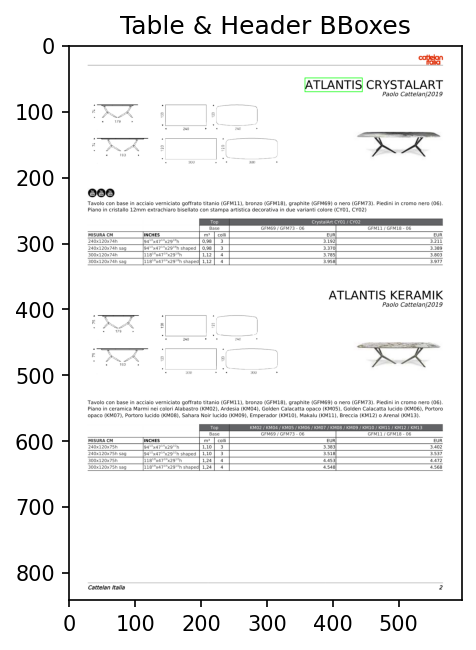

In [124]:
### TEST CODE BLOCK

def show_image(item, title=""):
    """Display a pixmap.

    Just to display Pixmap image of "item" - ignore the man behind the curtain.

    Args:
        item: any PyMuPDF object having a "get_pixmap" method.
        title: a string to be used as image title

    Generates an RGB Pixmap from item using a constant DPI and using matplotlib
    to show it inline of the notebook.
    """
    DPI = 150  # use this resolution
    import numpy as np
    import matplotlib.pyplot as plt

    # %matplotlib inline
    pix = item.get_pixmap(dpi=DPI)
    img = np.ndarray([pix.h, pix.w, 3], dtype=np.uint8, buffer=pix.samples_mv)
    plt.figure(dpi=DPI)  # set the figure's DPI
    plt.title(title)  # set title of image
    _ = plt.imshow(img, extent=(0, pix.w * 72 / DPI, pix.h * 72 / DPI, 0))

pdf_path = "./files/Cattelan Italia ITALIA 08.01.21-pages-2-11.pdf"
doc = fitz.open(pdf_path)
print("doc num pages =", len(doc))
page_render = doc[0]
instances = None

for page_num in range(len(doc)):
    page = doc[page_num]    
    # to get y-coordinate of product name. Try uppercase version first (most common in catalogs)
    instances = page.search_for("ATLANTIS")
    if instances:
        print("page num: ", page_num)
        print("instance:\n", instances[0])
        break


page_render.draw_rect(instances[0],color=fitz.pdfcolor["green"])


# for page_num in range(len(doc)):
#     page = doc[page_num]
#     search_term = "BUTTERFLY"

#     instances = page.search_for(search_term)
#     if instances:
#         for instance in instances:
#             print("-------")
#             surrounding_text = page.get_textbox(instance)
#             print("page num: ", page_num+1)
#             print(surrounding_text)
#             if surrounding_text.strip() == search_term:
#                 print(f"Found exact match in on page {page_num + 1}")
#                 page_render = page


# sample_gemini_output = """{"BUTTERFLY KERAMIK": {"brand_name": "Cattelan Italia", "designer": "nucleo+", "year": 2020, "type_of_product": "Tavolo", "all_colors": [{"Alabastro": "KM02"}, {"Ardesia": "KM04"}, {"Golden Calacatta opaco": "KM05"}, {"Golden Calacatta lucido": "KM06"}, {"Portoro opaco": "KM07"}, {"Portoro lucido": "KM08"}, {"Sahara Noir lucido": "KM09"}, {"Emperador": "KM10"}, {"Makalu": "KM11"}, {"Breccia": "KM12"}, {"Arenal": "KM13"}, {"Titanio": "GFM11"}, {"Bronzo": "GFM18"}, {"Brushed Bronze": null}, {"Brushed Grey": null}], "page_reference": null}, "CARIOCA": {"brand_name": "Cattelan Italia", "designer": "Andrea Lucatello", "year": 2014, "type_of_product": "Tavolo", "all_colors": [{"Noce Canaletto": "NC"}, {"Cristallo trasparente": null}, {"Cristallo trasparente extrachiaro bisellato": null}], "page_reference": null}}"""
# find_next_product_location(doc, 4, "BUTTERFLY KERAMIK", json.loads(output))

# instance = doc[4].search_for("CARIOCA")
# print(instance)
# page.draw_rect(instance[0],color=fitz.pdfcolor["green"])

# tables = page.find_tables()
# print("tables = ", type(tables))

# for table in tables:
#     table_bbox = table.bbox  # table boundary box
#     print(table_bbox)

# for i,table in enumerate(tables):  # iterate over all tables
#     page.draw_rect(table.bbox,color=fitz.pdfcolor["green"])
#     print(f"Table {i} column names: {table.header.names}, external: {table.header.external}")
    
show_image(page_render, f"Table & Header BBoxes")

# Table Extraction Method 1 (old)
1-step processing using VLMs (not great results)
1. input table image
2. **produce all combinations** of attributes in json list of objects (can be 50-100+ objects)



### the prompts (old, unused)

In [ ]:
NUM_COMBINATIONS = 32

prompt="""
I want you to parse a furniture pricing table step-by-step from an image and output the data in JSON format.
The table describes combinations of attributes, each represented by row and column headers.

Here's the task:
INPUT:
An image of a complex table with pricing information based on several attributes: "Top" and "Base" color codes (separated by /), dimensions in cm and inches, volume (M3), Colli (presumably package quantity), and price (EUR).
There might be nested sub-categories and some columns might be combined (noted by the "/" symbol) if their pricing information is the same to save visual space but we need to unpack them to reveal all combinations

PROCESSING:
1. identify all combinations of attributes. If combined or nested, split each value based on the delimiter used ("/" in this case)
2. calculate and output the number of combinations total.
3. for each combination of attributes, identify the price and output all combinations based on the format below.

OUTPUT:
A JSON array of objects, where each object represents a unique combination of "Top," "Base," dimensions, and price. The JSON format should be:
[
  {
    "Top": "Top color from image",
    "Base": "Base color from image (with classification and/or number)",
    "Dimensions_CM": "Dimensions in cm from image",
    "Dimensions_INCHES": "Dimensions in inches from image",
    "M3": "M3 value from image",
    "Colli": "Colli value from image",
    "EUR": "EUR price from image"
  },
  ... // More objects for other combinations
]"""

new_prompt = f"""
I want you to parse a furniture pricing table step-by-step from an image and output the data in JSON format.
The table describes combinations of attributes, each represented by row and column headers.
There are {NUM_COMBINATIONS} total combinations, based on the calculation below

CALCULATION OF COMBINATIONS:
Here's the breakdown of combinations from the image:
1. Top:  CrystalArt CY01, CrystalArt CY02 (2 options)
2. Base: GFM69, GFM73, GFM11, GFM18 (4 options)
3. Dimensions (cm/inches): 240x120x74h, 240x120x74h sag, 300x120x74h, 300x120x74h sag (4 options -  Note: Though represented in both cm and inches, these are the same dimensions, just in different units, so they count as one attribute)
Calculation:
Total combinations = Top options * Base options * Dimension options
Total combinations = 2 * 4 * 4 = 32

TASK INPUT:
An image of a complex table with pricing information based on several attributes: "Top" and "Base" color codes (separated by /), dimensions in cm and inches, volume (M3), Colli (presumably package quantity), and price (EUR).
There might be nested sub-categories and some columns might be combined (noted by the "/" symbol) if their pricing information is the same to save visual space but we need to unpack them to reveal all combinations

TASK OUTPUT:
A JSON array of {NUM_COMBINATIONS} objects, where each object represents a unique combination of "Top," "Base," dimensions, and price. Each object has the following attributes:

ATTRIBUTES:
- "Top": "Top color from image",
- "Base": "Base color from image (with classification and/or number)",
- "Dimensions_CM": "Dimensions in cm from image",
- "Dimensions_INCHES": "Dimensions in inches from image",
- "M3": "M3 value from image",
- "Colli": "Colli value from image",
- "EUR": "EUR price from image"
"""

prompt_table_structure = """
You are analyzing a furniture pricing table in an image. You will pre-process this table
Your task is to extract all headers (aka attributes of the furniture) and basic structure of the table accurately. Here's what you need to do:

1. Identify all headers in the table, including those that are combined to save space. For eg some header values might be combined into 1 column separated by the forward slash "/"
2. Provide a JSON output for the headers, including all permutations or combinations of headers.

This output schema will be used to then extract actual pricing data for each combination of attributes.
"""

prompt_combination_count = """
I want you to parse a furniture pricing table step-by-step from an image and output the number of combinations of the data.
The table describes combinations of attributes, each represented by row and column headers.

Here's the task:
INPUT:
An image of a complex table with pricing information based on several attributes: "Top" and "Base" color codes (separated by /), dimensions in cm and inches, volume (M3), Colli (presumably package quantity), and price (EUR).
There might be nested sub-categories and some columns might be combined (noted by the "/" symbol) if their pricing information is the same to save visual space but we need to unpack them to reveal all combinations

PROCESSING:
1. identify all combinations of attributes. If combined or nested, split each value based on the delimiter used ("/" in this case)
2. calculate and output the number of combinations total.

OUTPUT:
The number of total combinations along with the formula used.
"""


### calling Gemini

In [ ]:
import os
import google.generativeai as genai
from google.colab import userdata


# Create the model
generation_config = {
  "response_mime_type": "application/json",
}

genai.configure(api_key=userdata.get('gemini_api_key'))
model = genai.GenerativeModel(
    "gemini-1.5-pro-002"
    # generation_config=generation_config
    # system_instruction=""
)

# UPLOAD TABLE IMAGE TO GEMINI
def upload_to_gemini(path, mime_type=None):
  # """Uploads the given file to Gemini.
  # See https://ai.google.dev/gemini-api/docs/prompting_with_media
  # """
  file = genai.upload_file(path, mime_type=mime_type)
  print(f"Uploaded file '{file.display_name}' as: {file.uri}")
  return file

def process_image_gemini(image_path, prompt, generation_config=None):
    # Upload the image to Gemini
    files = [
        upload_to_gemini(image_path, mime_type="image/png"),
    ]

    # Create the prompt object
    prompt_obj = {
        "parts": [
            files[0],
            prompt
        ]
    }

    # Generate content using the Gemini model
    if generation_config:
        response = model.generate_content(prompt_obj, generation_config=generation_config)
    else:
        response = model.generate_content(prompt_obj)

    print(response.text)
    return response.text


In [ ]:
image_data = process_image_gemini(local_path, new_prompt, generation_config)

Uploaded file 'table_image.png' as: https://generativelanguage.googleapis.com/v1beta/files/apte9sowvozl
[{"Top": "CrystalArt CY01", "Base": "GFM69", "Dimensions_CM": "240x120x74h", "Dimensions_INCHES": "94 1/2x47 1/4x29 1/8h", "M3": "0.98", "Colli": "3", "EUR": "3.192"}, {"Top": "CrystalArt CY01", "Base": "GFM73", "Dimensions_CM": "240x120x74h", "Dimensions_INCHES": "94 1/2x47 1/4x29 1/8h", "M3": "0.98", "Colli": "3", "EUR": "3.192"}, {"Top": "CrystalArt CY02", "Base": "GFM69", "Dimensions_CM": "240x120x74h", "Dimensions_INCHES": "94 1/2x47 1/4x29 1/8h", "M3": "0.98", "Colli": "3", "EUR": "3.211"}, {"Top": "CrystalArt CY02", "Base": "GFM73", "Dimensions_CM": "240x120x74h", "Dimensions_INCHES": "94 1/2x47 1/4x29 1/8h", "M3": "0.98", "Colli": "3", "EUR": "3.211"}, {"Top": "CrystalArt CY01", "Base": "GFM11", "Dimensions_CM": "240x120x74h", "Dimensions_INCHES": "94 1/2x47 1/4x29 1/8h", "M3": "0.98", "Colli": "3", "EUR": "3.211"}, {"Top": "CrystalArt CY01", "Base": "GFM18", "Dimensions_CM":

### Calling gpt4o


### file upload (unused)

In [ ]:
import requests
import os

# upload a image table to azure openai
def upload_file_to_azure_openai(file_path, purpose, api_key, endpoint):
    url = f"{endpoint}openai/files?api-version=2024-10-21"

    headers = {"api-key": api_key}

    # Validate file existence
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")

    # using openai azure client to directly upload
    with open(file_path, "rb") as image_file:
      file_response = client.files.create(
        file=image_file,
        purpose=purpose
    )
    # file_id = file_response.id
    return file_response

# call the function
file_path = "/content/table-image.png"  # Replace with your file path
purpose = "assistants"  # Purpose, such as fine-tuning or evaluation
response = upload_file_to_azure_openai(file_path, purpose, OAI_API_KEY, ENDPOINT)

if response:
    print("File uploaded successfully! Response:")
    print(response)
else:
    print("Failed to upload the file.")


File uploaded successfully! Response:
FileObject(id='assistant-f5K3gnNAPdGwAJDH6rMG4CyT', bytes=78771, created_at=1733101104, filename='table-image.png', object='file', purpose='assistants', status='processed', status_details=None)


### prompt definitions (new) & creation

### calling llm gpt-4o

In [ ]:
image_path = "/content/table-image.png"
image_data_gpt4o = process_image_gpt4o(image_path, messages)

Failed to parse response, Error: Error code: 400 - {'error': {'code': 'BadRequest', 'message': 'Invalid image URL. The URL must be a valid HTTP or HTTPS URL, or a data URL with base64 encoding.', 'param': None, 'type': None}}


In [ ]:
import json
import pandas as pd

gpt4o_json = json.loads(image_data_gpt4o).get("result")
print(gpt4o_json)
print(len(gpt4o_json))

pd.DataFrame.from_records(gpt4o_json)

TypeError: the JSON object must be str, bytes or bytearray, not NoneType

## Misc, unused

### Misc below (unused stuff from Alex undatas)

In [ ]:
read_table_model = genai.GenerativeModel(
  model_name="gemini-1.5-pro",
  generation_config=generation_config,
  system_instruction="""Task Description: Read the table information in the image and extract the data requested by the user.
Image Description: The image contains a complex table.
Task Process Description: First, carefully examine the image to understand the table structure. Then, understand the user's request to extract the desired data. Finally, output the data in JSON format.
JSON Format:
[Extracted Data]""",
)

def get_image_top_data(image_path, part):
    # TODO Make these files available on the local file system
    # You may need to update the file paths
    files = [
      upload_to_gemini(image_path, mime_type="image/png"),
    ]
    chat_session = read_table_model.start_chat(
      history=[
        {
          "role": "user",
          "parts": [
            files[0],
            part,
          ],
        }
      ]
    )

    response = chat_session.send_message("INSERT_INPUT_HERE")

    print(response.text)
    return response.text

In [ ]:
get_image_top_data_part = "Get the 'Top' data from the table, split it using '/', and return the data in JSON format."
top_data = get_image_top_data(local_path, get_image_top_data_part)
top_data

Uploaded file 'table_image.png' as: https://generativelanguage.googleapis.com/v1beta/files/mxzre3wmwi4h
["CY01", "CY02"]


'["CY01", "CY02"]'

In [ ]:
top_list = json.loads(top_data)

table_json_data = []
for top in top_list:
   one_json_data = []
   for base in one_top_data:
      one_base = base.copy()
      one_base['Top'] = top
      one_json_data.append(one_base)
   table_json_data.extend(one_json_data)

print(table_json_data)
table_df = pd.DataFrame.from_records(table_json_data)
table_df

[{'Top': 'CY01', 'Base': 'GFM69-06', 'Dimensions_CM': '240x120x74h', 'Dimensions_INCHES': '94 1/2x47 1/4x29 1/8h', 'M3': '0.98', 'Colli': '3', 'EUR': '3.192'}, {'Top': 'CY01', 'Base': 'GFM73-06', 'Dimensions_CM': '240x120x74h', 'Dimensions_INCHES': '94 1/2x47 1/4x29 1/8h', 'M3': '0.98', 'Colli': '3', 'EUR': '3.192'}, {'Top': 'CY01', 'Base': 'GFM11-06', 'Dimensions_CM': '240x120x74h', 'Dimensions_INCHES': '94 1/2x47 1/4x29 1/8h', 'M3': '0.98', 'Colli': '3', 'EUR': '3.211'}, {'Top': 'CY01', 'Base': 'GFM18-06', 'Dimensions_CM': '240x120x74h', 'Dimensions_INCHES': '94 1/2x47 1/4x29 1/8h', 'M3': '0.98', 'Colli': '3', 'EUR': '3.211'}, {'Top': 'CY01', 'Base': 'GFM69-06', 'Dimensions_CM': '240x120x74h sag', 'Dimensions_INCHES': '94 1/2x47 1/4x29 1/8h shaped', 'M3': '0.98', 'Colli': '3', 'EUR': '3.370'}, {'Top': 'CY01', 'Base': 'GFM73-06', 'Dimensions_CM': '240x120x74h sag', 'Dimensions_INCHES': '94 1/2x47 1/4x29 1/8h shaped', 'M3': '0.98', 'Colli': '3', 'EUR': '3.370'}, {'Top': 'CY01', 'Base':

,Top,Base,Dimensions_CM,Dimensions_INCHES,M3,Colli,EUR
0,CY01,GFM69-06,240x120x74h,94 1/2x47 1/4x29 1/8h,0.98,3,3.192
1,CY01,GFM73-06,240x120x74h,94 1/2x47 1/4x29 1/8h,0.98,3,3.192
2,CY01,GFM11-06,240x120x74h,94 1/2x47 1/4x29 1/8h,0.98,3,3.211
3,CY01,GFM18-06,240x120x74h,94 1/2x47 1/4x29 1/8h,0.98,3,3.211
4,CY01,GFM69-06,240x120x74h sag,94 1/2x47 1/4x29 1/8h shaped,0.98,3,3.370
5,CY01,GFM73-06,240x120x74h sag,94 1/2x47 1/4x29 1/8h shaped,0.98,3,3.370
6,CY01,GFM11-06,240x120x74h sag,94 1/2x47 1/4x29 1/8h shaped,0.98,3,3.389
7,CY01,GFM18-06,240x120x74h sag,94 1/2x47 1/4x29 1/8h shaped,0.98,3,3.389
8,CY01,GFM69-06,300x120x74h,118 1/8x47 1/4x29 1/8h,1.12,4,3.785
9,CY01,GFM73-06,300x120x74h,118 1/8x47 1/4x29 1/8h,1.12,4,3.785


In [ ]:
table_df.to_excel('table_data.xlsx')